# Feature Importance

In [1]:
# ============================================================
# 0. 基础设置：导入库 & 读入数据
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import shap
import warnings
warnings.filterwarnings("ignore")

# 读取数据
df = pd.read_csv("../data/train.csv")

# 定义三个“预测指标”作为目标
targets = ["forward_returns", "risk_free_rate", "market_forward_excess_returns"]
targets = [t for t in targets if t in df.columns]

# 只用数值型特征，去掉目标列
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in num_cols if c not in targets]

X = df[feature_cols].copy()
y_dict = {t: df[t].values for t in targets}

print("n_samples:", len(df))
print("n_features:", len(feature_cols))
print("targets:", targets)

# 简单时间顺序切分（如果不是时间序列你可以改成 shuffle=True）
X_train, X_valid = train_test_split(
    X, test_size=0.2, shuffle=False
)
y_train_dict = {}
y_valid_dict = {}
for t in targets:
    y_train_dict[t] = y_dict[t][: len(X_train)]
    y_valid_dict[t] = y_dict[t][len(X_train):]

n_samples: 9021
n_features: 95
targets: ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']


## 1. LightGBM Importance

In [2]:
# ============================================================
# 1. 训练 LightGBM 模型（每个目标一个）
# ============================================================
models = {}

for t in targets:
    model = LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train, y_train_dict[t])
    models[t] = model

print("Trained models for:", list(models.keys()))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21647
[LightGBM] [Info] Number of data points in the train set: 7216, number of used features: 95
[LightGBM] [Info] Start training from score 0.000435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21647
[LightGBM] [Info] Number of data points in the train set: 7216, number of used features: 95
[LightGBM] [Info] Start training from score 0.000108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21647
[LightGBM] [Info] Number of data points in the train set: 7216, number of used features: 95
[LightGBM] [Info] Start tra

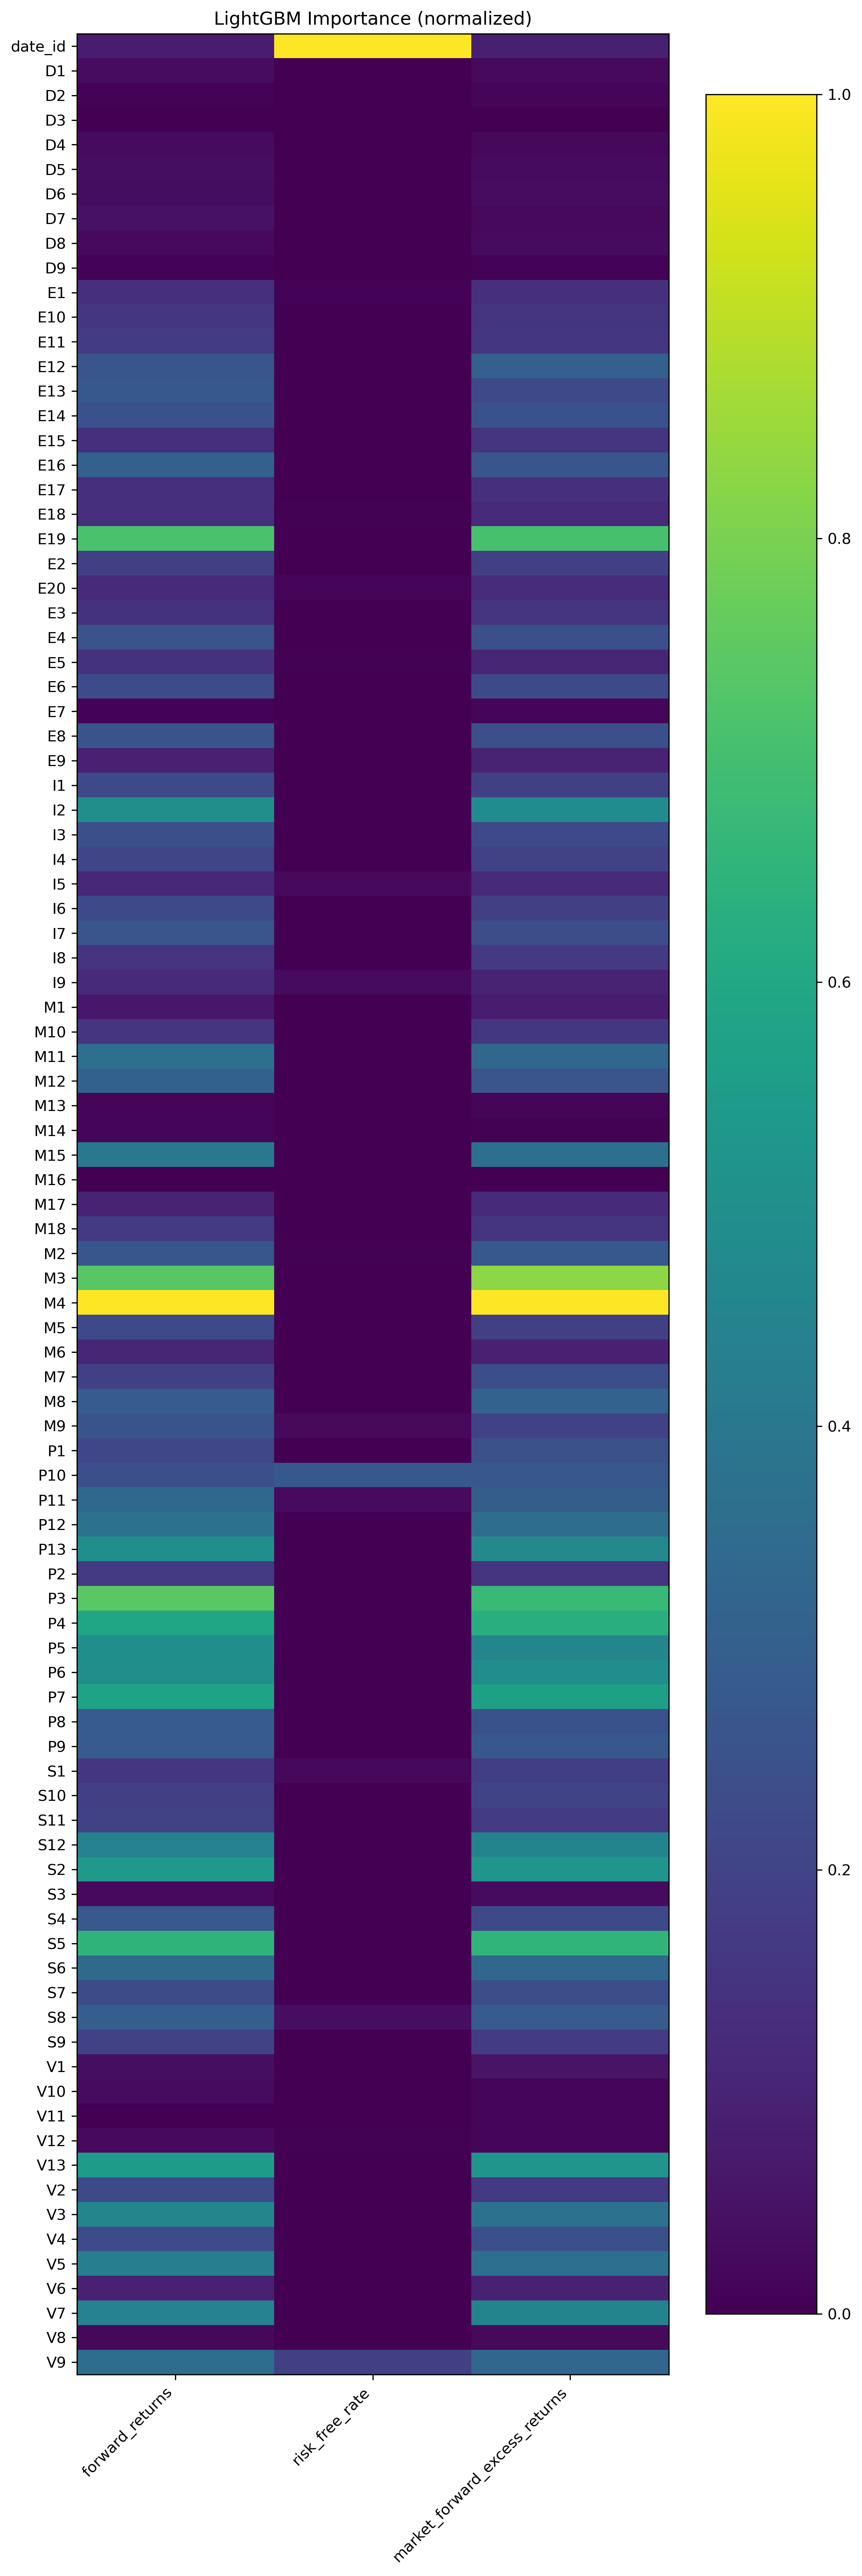

In [4]:
# ============================================================
# 2. LightGBM importance 热力图
# ============================================================
# importance_type: "split" / "gain" 都可以，这里用 gain
plt.rcParams["figure.dpi"] = 300

lgb_importance = pd.DataFrame(index=feature_cols, columns=targets, dtype=float)

for t in targets:
    imp = models[t].feature_importances_
    # LightGBM 默认是 split 次数；如果想用 gain，可以用 booster_.feature_importance("gain")
    # 这里我们改成 gain 更常用：
    imp_gain = models[t].booster_.feature_importance(importance_type="gain")
    lgb_importance[t] = imp_gain

# 归一化到 [0,1]，便于画图
lgb_importance_norm = lgb_importance.div(lgb_importance.max(axis=0))

def plot_heatmap(mat: pd.DataFrame, title: str):
    """简单的 matplotlib 热力图（行：feature；列：target）"""
    plt.figure(figsize=(8, max(6, len(mat) * 0.25)))
    im = plt.imshow(mat.values, aspect="auto")
    plt.colorbar(im)
    plt.yticks(range(len(mat.index)), mat.index)
    plt.xticks(range(len(mat.columns)), mat.columns, rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(lgb_importance_norm, "LightGBM Importance (normalized)")

## 2. Permutation importance

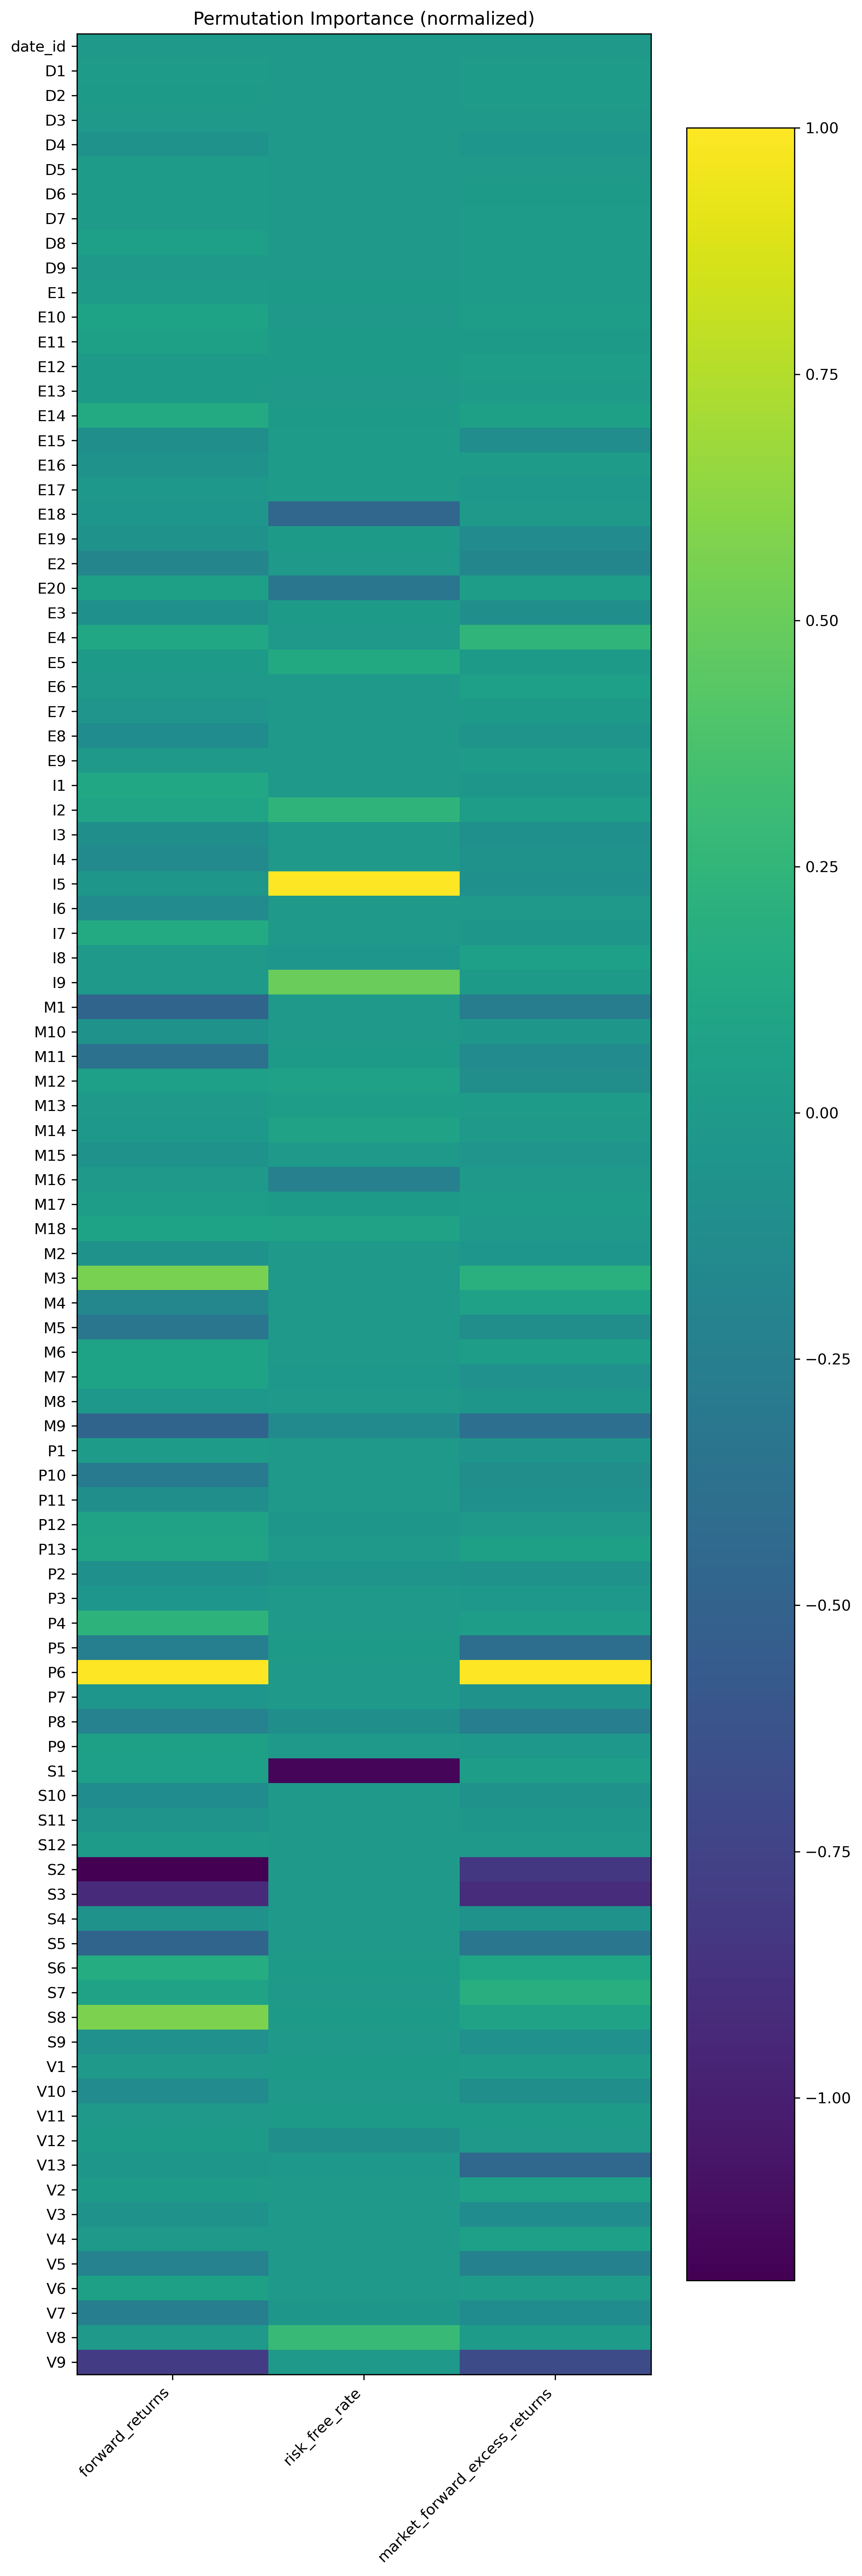

In [5]:
# ============================================================
# 3. Permutation importance 热力图
#    注意：这个比较耗时，可以酌情减少 n_repeats 或抽样
# ============================================================
perm_importance = pd.DataFrame(index=feature_cols, columns=targets, dtype=float)

# 为了速度，选一小部分验证集做 permutation（可按需要调整）
perm_X = X_valid.copy()
perm_subsample = min(2000, len(perm_X))
perm_X = perm_X.iloc[:perm_subsample]
perm_idx = perm_X.index

for t in targets:
    model = models[t]
    y_valid = y_valid_dict[t][perm_idx - perm_idx.min()]  # 保证索引对齐

    result = permutation_importance(
        model,
        perm_X,
        y_valid,
        n_repeats=10,
        random_state=42,
        n_jobs=-1,
        scoring="neg_mean_squared_error",
    )

    # importance 取 mean
    perm_importance[t] = result.importances_mean

perm_importance_norm = perm_importance.div(perm_importance.max(axis=0))

plot_heatmap(perm_importance_norm, "Permutation Importance (normalized)")

## 3. SHAP Importance

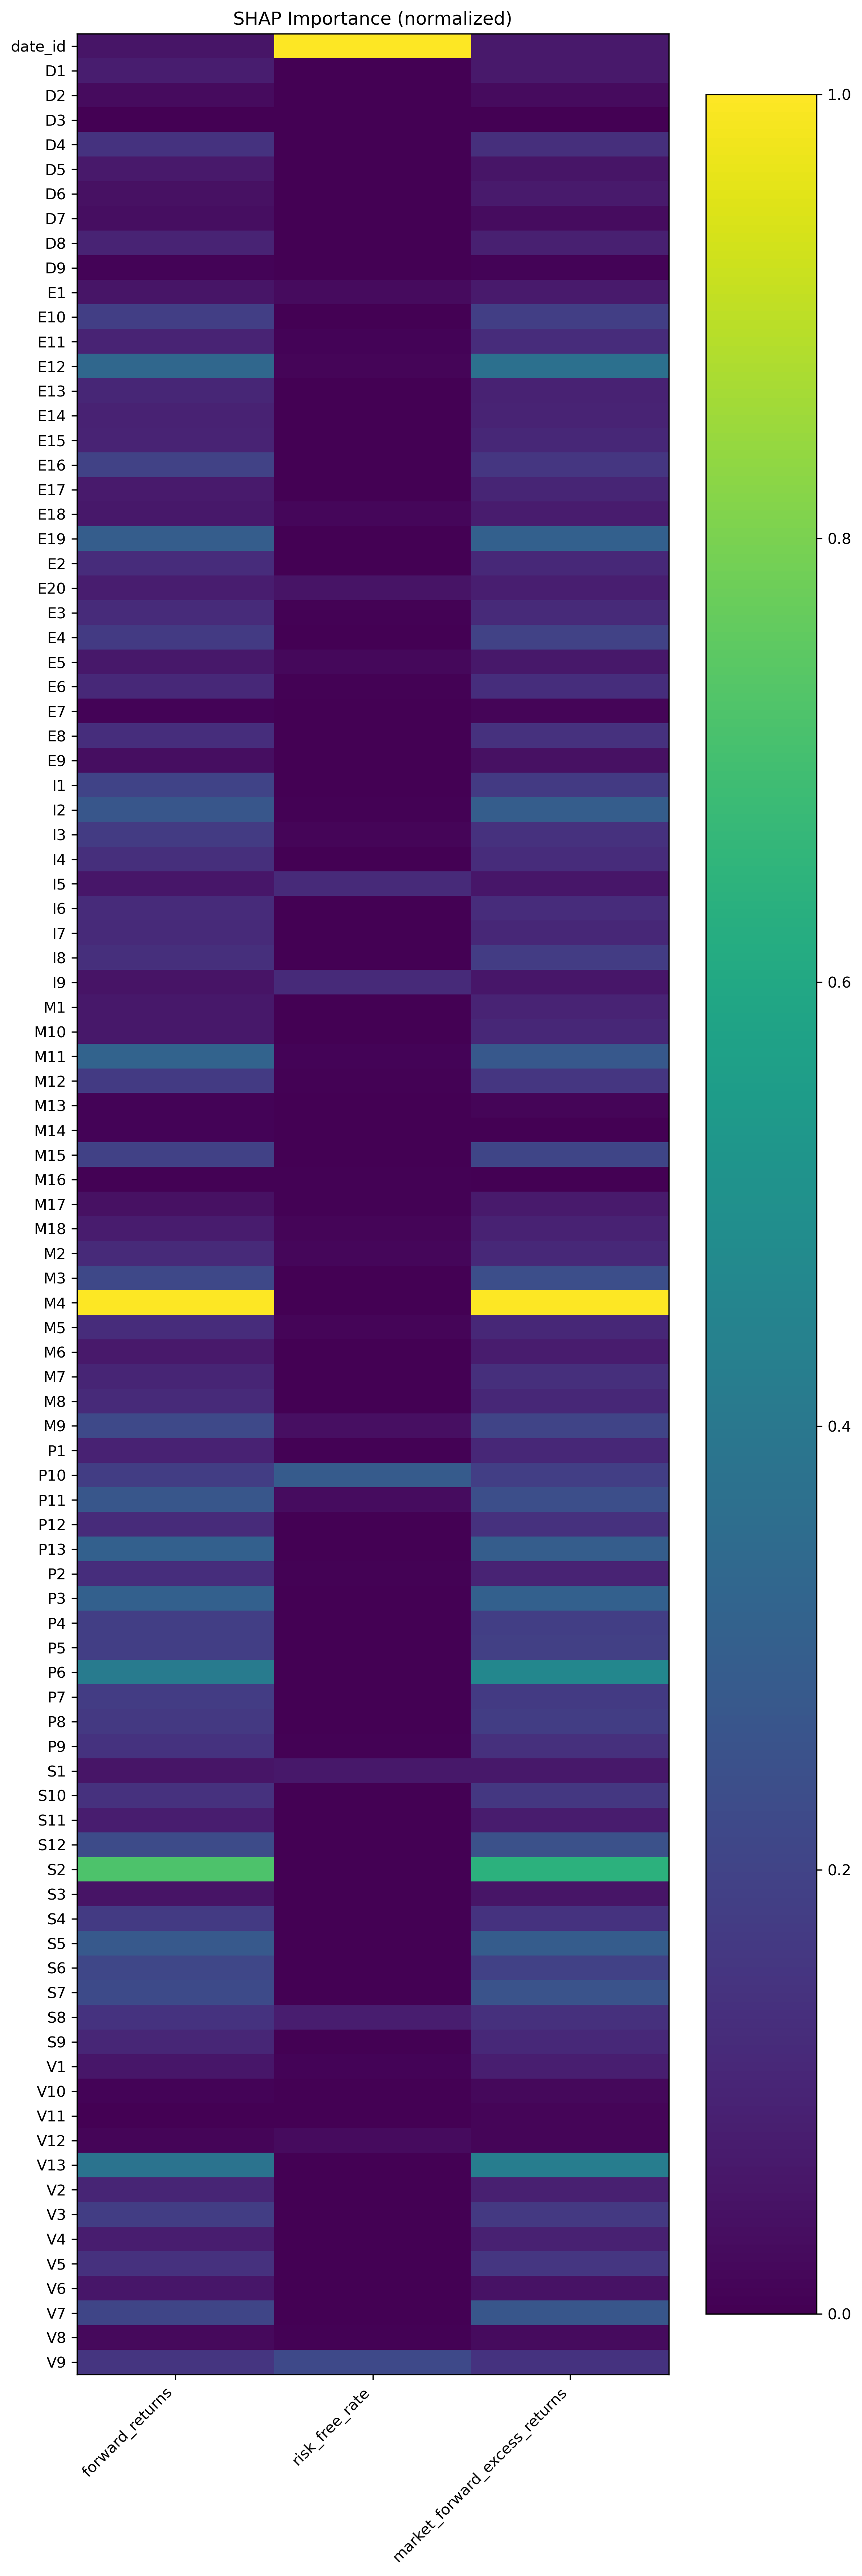

In [6]:
# ============================================================
# 4. SHAP importance 热力图
# ============================================================
# 只取一部分训练样本来算 SHAP，提升速度
shap_X = X_train.copy()
shap_subsample = min(2000, len(shap_X))
shap_X = shap_X.sample(shap_subsample, random_state=42)

shap_importance = pd.DataFrame(index=feature_cols, columns=targets, dtype=float)

for t in targets:
    model = models[t]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(shap_X)

    # 对回归模型：shap_values 是 (n_samples, n_features)
    # importance 取 |shap| 的平均值
    shap_vals = np.abs(shap_values).mean(axis=0)
    shap_importance[t] = shap_vals

shap_importance_norm = shap_importance.div(shap_importance.max(axis=0))

plot_heatmap(shap_importance_norm, "SHAP Importance (normalized)")

## 4. Combined

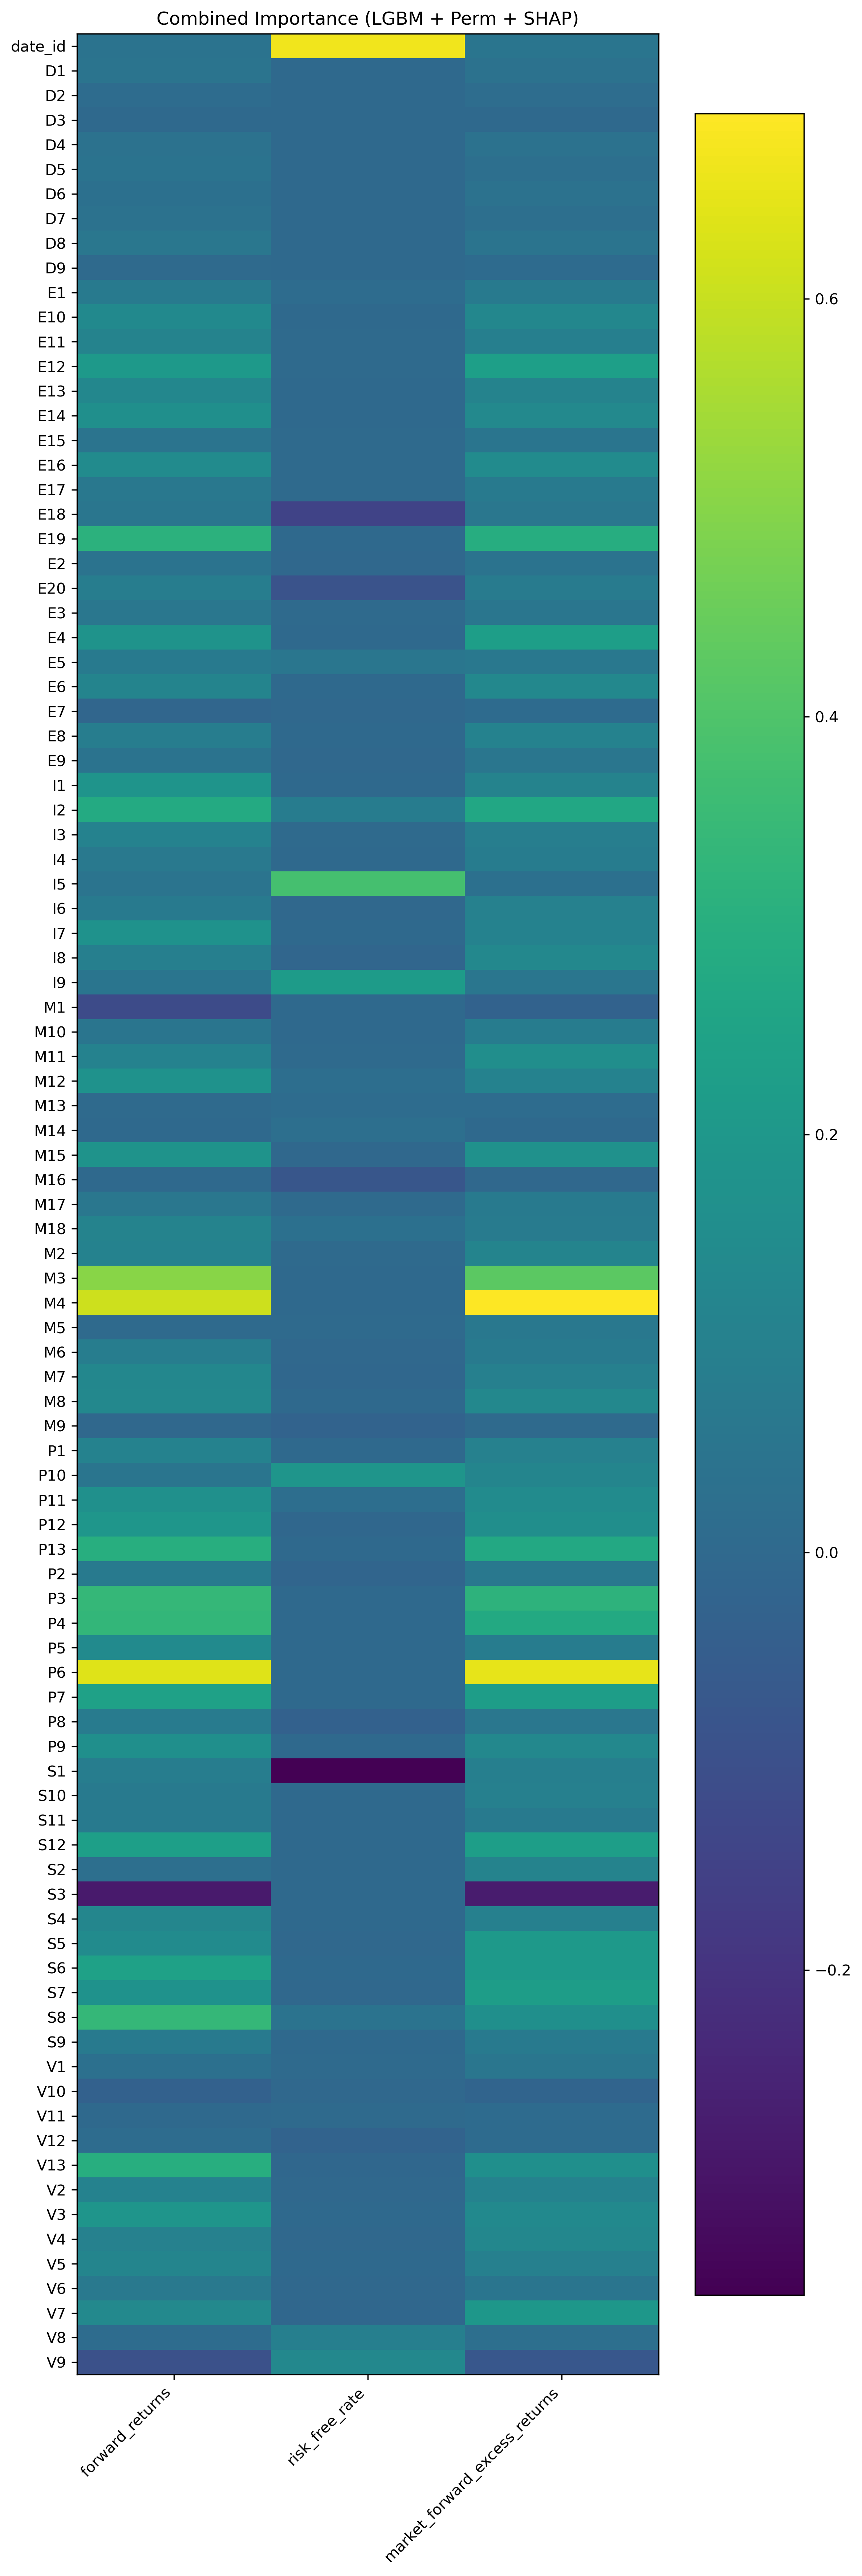

In [7]:
# ============================================================
# 5. 综合重要性热力图
#    做法：三个重要性矩阵先各自列归一化到 [0,1]，再简单平均
# ============================================================
# 已经分别归一化过：lgb_importance_norm / perm_importance_norm / shap_importance_norm

combined_importance = (
    lgb_importance_norm.fillna(0) +
    perm_importance_norm.fillna(0) +
    shap_importance_norm.fillna(0)
) / 3.0

plot_heatmap(combined_importance, "Combined Importance (LGBM + Perm + SHAP)")

## 5. Feature-Feature Interaction Importance (SHAP Interaction)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19782
[LightGBM] [Info] Number of data points in the train set: 9021, number of used features: 87
[LightGBM] [Info] Start training from score 0.000471


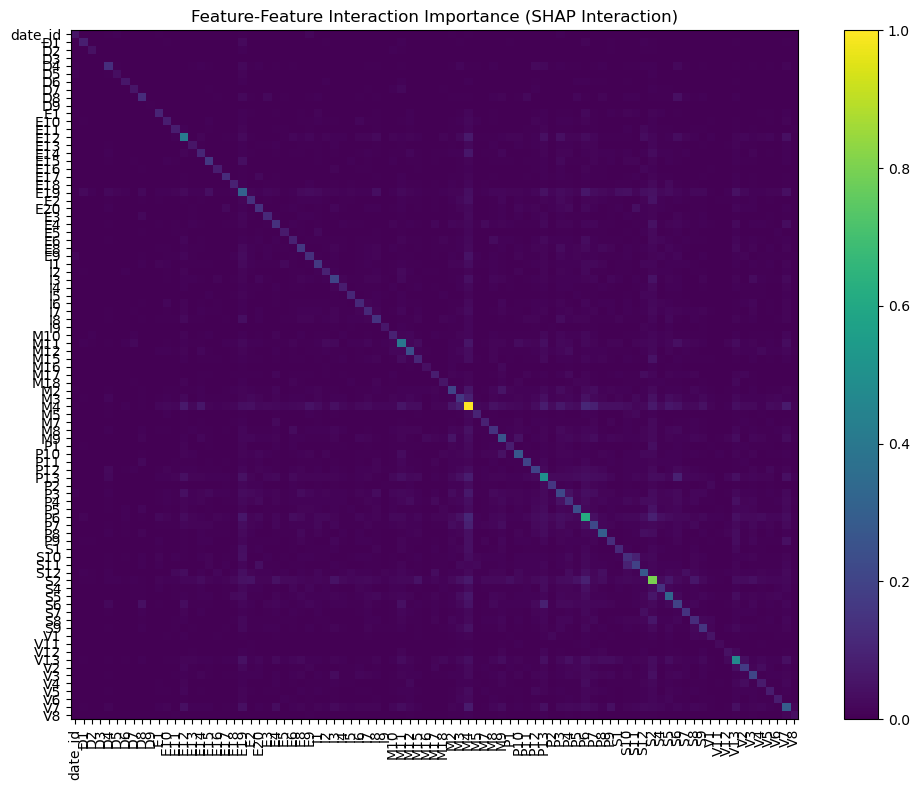

In [1]:
# ==============================================================
# 0. 导入与数据准备
# ==============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import shap

df = pd.read_csv("../data/train.csv")

# 去掉含大量缺失值的特征（如 >50% 缺失，可根据需要调整）
missing_pct = df.isna().sum() / len(df)
feature_cols = missing_pct[missing_pct < 0.5].index.tolist()

# 去掉目标列
targets = ["forward_returns", "risk_free_rate", "market_forward_excess_returns"]
feature_cols = [c for c in feature_cols if c not in targets]

X = df[feature_cols].fillna(df[feature_cols].median())  # 处理少量缺失
y = df["forward_returns"]  # 选一个主要 return 目标即可（你可以换成 excess returns）

# 训练模型
model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)
model.fit(X, y)

# ==============================================================
# 1. 计算 SHAP interaction values
# ==============================================================
# 由于 SHAP 计算较重，我们采样部分数据
sample_size = min(2000, len(X))
X_sample = X.sample(sample_size, random_state=42)

explainer = shap.TreeExplainer(model)
shap_inter = explainer.shap_interaction_values(X_sample)

# shap_inter shape = (n_samples, n_features, n_features)
# 取绝对值平均得到相互重要性矩阵
interaction_matrix = np.abs(shap_inter).mean(axis=0)

interaction_df = pd.DataFrame(
    interaction_matrix,
    index=feature_cols,
    columns=feature_cols
)

# 标准化，便于效果一致
interaction_norm = interaction_df / interaction_df.max().max()

# ==============================================================
# 2. 画特征之间的相互重要性热力图
# ==============================================================
plt.figure(figsize=(10, 8))
im = plt.imshow(interaction_norm.values, aspect="auto", cmap="viridis")
plt.colorbar(im)
plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
plt.yticks(range(len(feature_cols)), feature_cols)
plt.title("Feature-Feature Interaction Importance (SHAP Interaction)")
plt.tight_layout()
plt.show()